
# NLP From Scratch: Classifying Names with a Character-Level RNN

Name by Gender
--------------

In [107]:
%matplotlib inline

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import csv
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

nome_arquivo = '/content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/data/name_gender.csv'  # Substitua pelo nome do seu arquivo
category_lines = {"M": [], "F": []}

with open(nome_arquivo, mode='r') as arquivo_csv:
    leitor_csv = csv.reader(arquivo_csv)
    next(leitor_csv, None)

    for linha in leitor_csv:
        nome, genero, _ = linha
        if genero == "M":
            category_lines["M"].append(unicodeToAscii(nome))
        elif genero == "F":
            category_lines["F"].append(unicodeToAscii(nome))

all_categories = ["M","F"]
n_categories = len(all_categories)

In [4]:
print(category_lines['M'][:5])

['Aaban', 'Aabid', 'Aadam', 'Aadan', 'Aadarsh']


### Turning Names into Tensors

In [49]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

In [89]:
import torch.nn as nn

class NameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, rnn_type='lstm'):
        super(NameRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers)

        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        h0 = torch.zeros(self.num_layers, input.size(1), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, input.size(1), self.hidden_size).to(input.device)

        out, _ = self.rnn(input, (h0, c0))
        out = out[-1]

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

hidden_size = 128
rnn = NameRNN(n_letters, hidden_size, n_categories, num_layers=2, rnn_type='lstm')


## Training

### Training the Network

In [99]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0005)

def train(category_tensor, line_tensor):
    optimizer.zero_grad()
    output = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()


In [100]:
import random
import time

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [101]:
from tqdm import tqdm

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  5%|▌         | 5018/100000 [00:29<11:12, 141.15it/s]

5000 5% 0.1382 Benjimen / M ✓


 10%|█         | 10022/100000 [00:58<11:07, 134.73it/s]

10000 10% 0.0048 Sandford / M ✓


 15%|█▌        | 15025/100000 [01:29<11:06, 127.50it/s]

15000 15% 0.1660 Verdis / M ✓


 20%|██        | 20022/100000 [01:57<09:34, 139.27it/s]

20000 20% 0.3201 Aleric / M ✓


 25%|██▌       | 25016/100000 [02:27<09:43, 128.57it/s]

25000 25% 0.1761 Odel / M ✓


 30%|███       | 30024/100000 [02:55<08:37, 135.16it/s]

30000 30% 0.1461 Sahit / M ✓


 35%|███▌      | 35016/100000 [03:24<08:15, 131.19it/s]

35000 35% 0.0708 Kimetra / F ✓


 40%|████      | 40016/100000 [03:53<06:51, 145.65it/s]

40000 40% 0.1769 Johnas / M ✓


 45%|████▌     | 45021/100000 [04:21<06:48, 134.45it/s]

45000 45% 0.0953 Seidy / F ✓


 50%|█████     | 50025/100000 [04:50<06:14, 133.36it/s]

50000 50% 0.0957 Taiwon / M ✓


 55%|█████▌    | 55032/100000 [05:18<04:15, 176.15it/s]

55000 55% 0.5297 Healy / F ✓


 60%|██████    | 60035/100000 [05:47<03:15, 204.27it/s]

60000 60% 0.1095 Rashim / M ✓


 65%|██████▌   | 65023/100000 [06:16<04:09, 140.30it/s]

65000 65% 0.0220 Brenon / M ✓


 70%|███████   | 70013/100000 [06:45<03:27, 144.20it/s]

70000 70% 0.2531 Kaymarie / F ✓


 75%|███████▌  | 75022/100000 [07:14<02:45, 151.17it/s]

75000 75% 0.0455 Renda / F ✓


 80%|████████  | 80033/100000 [07:42<01:42, 195.12it/s]

80000 80% 0.0188 Ayleah / F ✓


 85%|████████▌ | 85035/100000 [08:11<01:15, 198.89it/s]

85000 85% 0.0058 Tarkeshia / F ✓


 90%|█████████ | 90036/100000 [08:39<00:49, 203.02it/s]

90000 90% 0.0313 Sonjia / F ✓


 95%|█████████▌| 95024/100000 [09:07<00:25, 191.42it/s]

95000 95% 0.0428 Colgan / M ✓


100%|██████████| 100000/100000 [09:35<00:00, 173.65it/s]

100000 100% 0.3080 Vashanti / F ✓


### Plotting the Results




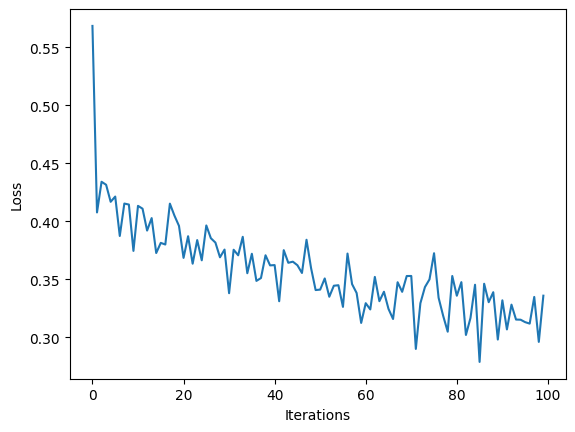

In [102]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Evaluating the Results




<ipython-input-103-cf7c0f795f9f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-103-cf7c0f795f9f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


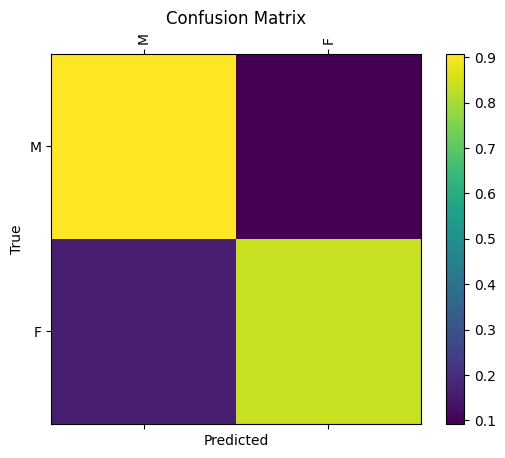

In [103]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = rnn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Running on User Input




In [104]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = rnn(lineToTensor(input_line))
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Make predictions
predict('John')
predict('Mary')
predict('Linda')


> John
(-0.04) M
(-3.17) F

> Mary
(-0.60) F
(-0.79) M

> Linda
(-0.03) F
(-3.68) M


#Salvar em PDF

In [105]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:


In [106]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/data/(first_name_by_gender)char_rnn_classification_tutorial.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/data/(first_name_by_gender)char_rnn_classification_tutorial.ipynb to PDF
[NbConvertApp] Support files will be in (first_name_by_gender)char_rnn_classification_tutorial_files/
[NbConvertApp] Making directory ./(first_name_by_gender)char_rnn_classification_tutorial_files
[NbConvertApp] Making directory ./(first_name_by_gender)char_rnn_classification_tutorial_files
[NbConvertApp] Writing 73769 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 113315 bytes to /content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/data/(first_name_by_gender)char_rnn_classification_tutorial